In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from os.path import join

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

In [3]:
anndata = sc.read_h5ad('../data/pbmc.virus.refine.7.h5ad')

In [4]:
selected_celltypes = ['mega', 'Mono-CD14-HLA', 'Mono-CD14-S100A8-RETN', 'Mono-CD14-S100A8-CD163',
                      'Mono-CD14-CCL3', 'Neu','Mono−CD16','T-CD4-FOS','T-CD4-LTB-S100A4','T-CD8-SLC4A10']

anndata_filtered = anndata[anndata.obs.louvain_celltype.isin(selected_celltypes), :]
meta = anndata_filtered.obs.copy()
meta['state2'] = meta.state.copy()
meta.state2 = meta.state2.astype('object')
meta.loc[meta[meta.source.isin(['HIV','Sepsis'])].index, 'state2'] = meta.loc[meta[meta.source.isin(['HIV','Sepsis'])].index, 'patients_time']
meta.loc[meta[meta.state2.isin(['1 Week','2 Weeks'])].index, 'state2'] = 'hyperacute'
meta.loc[meta[meta.state2.isin(['3 Weeks','4 Weeks','6 Months'])].index, 'state2'] = 'acute'
meta.loc[meta[meta.state2.isin(['Int-URO','URO'])].index, 'state2'] = 'sepsis.cohort1'
meta.loc[meta[meta.state2.isin(['ICU-SEP','Bac-SEP'])].index, 'state2'] = 'sepsis.cohort2'
meta.state2 = meta.state2.astype('category')

states = ['acute', 'hyperacute','sepsis.cohort1', 'sepsis.cohort2',
 'severe onset','moderate onset', 'control']
anndata_filtered.obs = meta
anndata_filtered = anndata_filtered[anndata_filtered.obs.state2.isin(states), :]
anndata_filtered.shape

(235194, 12753)

In [5]:
cytokine_genens = open('/home/liunianping/workspace/projects/Virus/Cytokines_analysis/data/merged.cytokines.txt').readlines()
cytokine_genens = [ item.strip('\n').strip() for item in cytokine_genens]
cytokine_genens_filtered = set(anndata_filtered.var.index.values).intersection(cytokine_genens)

In [6]:
from scipy.sparse import csc_matrix

### 筛选celltype
def grouped_obs_mean(adata, group_key):
    getX = lambda x: x.X
    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

### 筛选cytokine
def get_filtered_features(anndata:sc.AnnData, genes:list=list()):
    if genes:
        anndata = anndata[:, anndata.var_names.isin(genes)]
    celltype = []
    propotion = []
    g = anndata.obs.groupby('celltype_disease')
    for group, idx in g.indices.items():
        if group.split('_')[1]=='control':
            continue
        X = anndata[idx].X
        X = csc_matrix(X)
        celltype.append(group)
        propotion.append(np.asarray((X!=0).sum(axis=0))[0]/X.shape[0])
    propotion_df = pd.DataFrame(np.asarray(propotion), index=celltype, columns=anndata.var_names)
    
    def func(series, threshold=0.25):
        if np.sum(series>0.25)>0:
            return True
        return False
    
    mask = propotion_df.apply(func=func, axis=0)
    final_cytokines = propotion_df.columns[mask]
    return list(final_cytokines.values)

In [7]:
anndata_filtered.obs['celltype_disease'] = anndata_filtered.obs.louvain_celltype.str.cat(anndata_filtered.obs.state2, sep='_')
cytokine_genens_preserved = get_filtered_features(anndata_filtered, cytokine_genens_filtered)

Trying to set attribute `.obs` of view, copying.


In [8]:
anndata_filtered_filtered = anndata_filtered[:, anndata_filtered.var_names.isin(cytokine_genens_preserved)]
avg_exp = grouped_obs_mean(anndata_filtered_filtered, group_key='celltype_disease')
avg_exp_filtered = avg_exp
avg_exp_filtered = avg_exp_filtered.T
anndata_filtered_filtered.shape, len(cytokine_genens_preserved)

((235194, 39), 39)

In [10]:
row_colors_index = avg_exp_filtered.index[grid.dendrogram_row.reordered_ind]
row_colors_celltype = [item.split('_')[0] for item in row_colors_index]
row_colors_infection = [item.split('_')[1] for item in row_colors_index]
row_colors = pd.DataFrame({'Disease':row_colors_infection, 'Celltype':row_colors_celltype}, index=row_colors_index)

In [11]:
row_colors['Celltype'] = row_colors['Celltype'].map(dict(zip(anndata.obs.louvain_celltype.cat.categories, anndata.uns['louvain_celltype_index_colors'])))
row_colors['Disease'] = row_colors['Disease'].map({'acute':'#a6cee3','hyperacute':'#1f78b4','moderate onset':'#fb9a99','sepsis.cohort1':'#fdbf6f',
                                                   'sepsis.cohort2':'#ff7f00','severe onset':'#e31a1c','control':'#228B22'})

In [13]:
### delete HD
_index = avg_exp_filtered.index.values
bool_mask = [ False if item.split('_')[1]=='control' else True for item in _index]
_index = _index[bool_mask]
avg_exp_filtered_noHD = avg_exp_filtered.loc[_index, :]

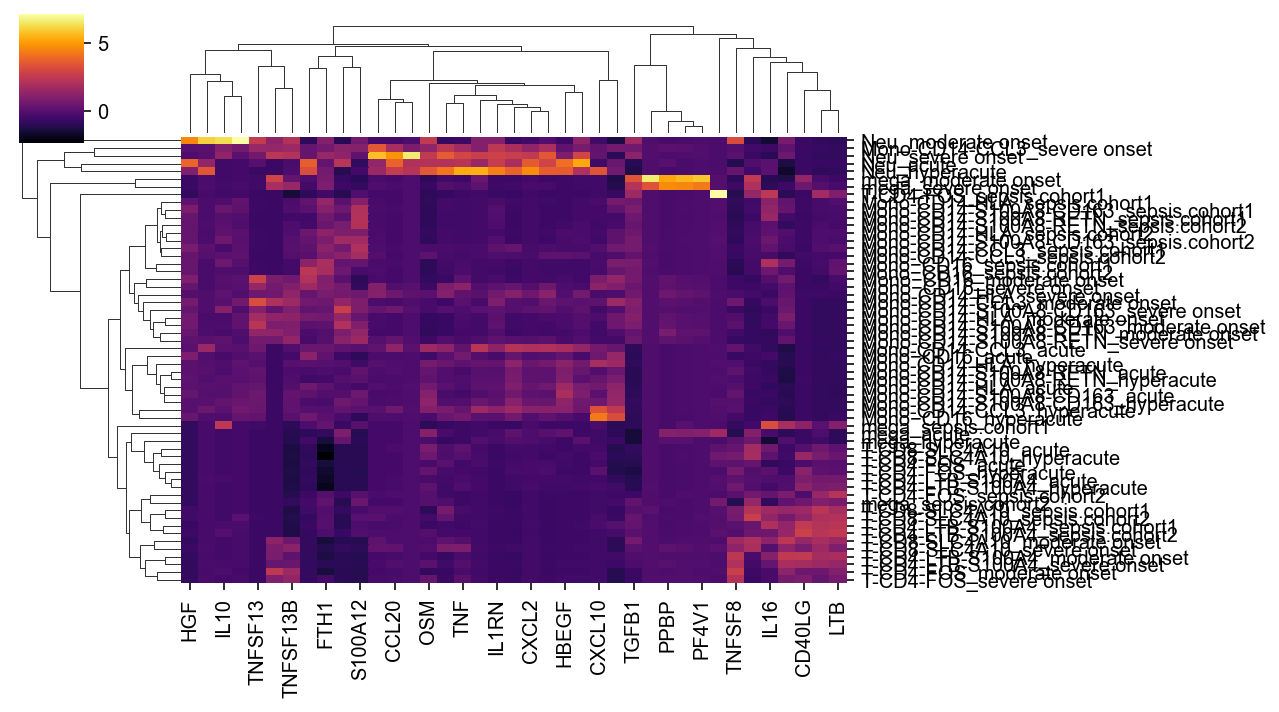

In [14]:
grid = sns.clustermap(avg_exp_filtered_noHD, z_score=1,
                      standard_scale=None, cmap='inferno',
                      figsize=(9, 5), yticklabels=True)

In [15]:
row_colors_index = avg_exp_filtered_noHD.index[grid.dendrogram_row.reordered_ind]
row_colors_celltype = [item.split('_')[0] for item in row_colors_index]
row_colors_infection = [item.split('_')[1] for item in row_colors_index]
row_colors = pd.DataFrame({'Disease':row_colors_infection, 'Celltype':row_colors_celltype}, index=row_colors_index)

In [16]:
row_colors['Celltype'] = row_colors['Celltype'].map(dict(zip(anndata.obs.louvain_celltype.cat.categories, anndata.uns['louvain_celltype_colors'])))
row_colors['Disease'] = row_colors['Disease'].map({'acute':'#a6cee3','hyperacute':'#1f78b4','moderate onset':'#fb9a99','sepsis.cohort1':'#fdbf6f',
                                                   'sepsis.cohort2':'#ff7f00','severe onset':'#e31a1c','control':'#228B22'})

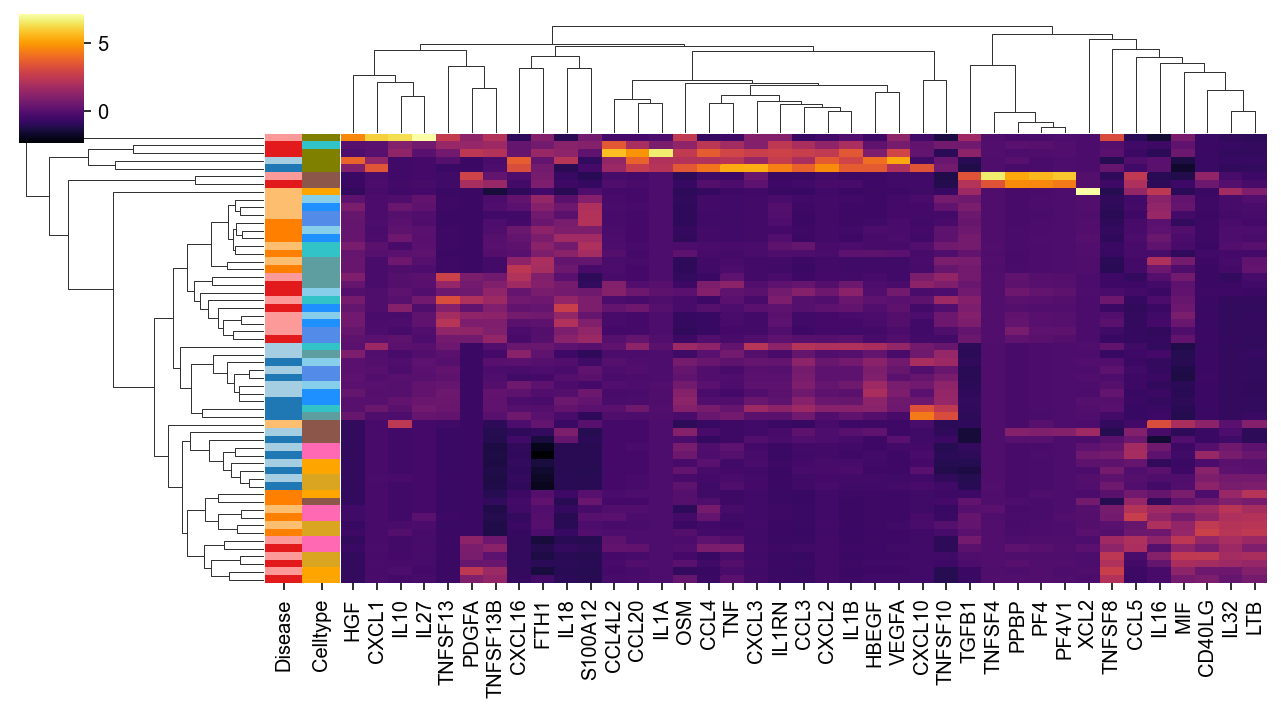

In [18]:
grid = sns.clustermap(avg_exp_filtered_noHD, z_score=1,
                      standard_scale=None, cmap='inferno',linewidths=0, linecolor='white',
                      figsize=(9, 5), yticklabels=False, xticklabels=True, row_colors=row_colors, rasterized=True)
plt.savefig('./figures/cytokine.heatmap.pdf', dpi=600)